In [1]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import spacy

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
# read in data

reddit = pd.read_csv('../data/reddit_small.csv')
reddit.shape

(4151, 2)

---
**Train-Test Split**

In [3]:
X = reddit[['clean_text']]
y = reddit['is_collapse']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3113, 1), (1038, 1), (3113,), (1038,))

---
**Baseline Model**

In [4]:
y_test.value_counts(normalize=True)
# 0 - futurology
# 1 - collapse
# basically 50-50, but slightly more futurology posts

0    0.50578
1    0.49422
Name: is_collapse, dtype: float64

In [5]:
X_train

,clean_text
2479,some guys are wrong
2244,does ai pose a large existential threat i ve b...
729,the world will think nuclear war if men conti...
1322,will you kill yourself when shtf me nah though...
4143,quantum satellites ok so i am not sure how far...
...,...
2596,will humans ever be able to create an iron man...
1439,growing economy economies of scale decreasing ...
948,when you have chopped down the last tree poiso...
1104,canadian housing market about to implode with ...


In [6]:
nlp = spacy.load('en_core_web_md')

X_train_nlp = X_train.applymap(nlp)

X_test_nlp = X_test.applymap(nlp)

In [7]:
def remove_stops(doc):
    '''
    fn that lemmatizes and removes stop words and punctuation
    '''
    return " ".join([token.lemma_ for token in doc if (not token.is_stop) and (not token.is_punct)])

In [8]:
X_train_stops = X_train_nlp.applymap(remove_stops)
X_test_stops = X_test_nlp.applymap(remove_stops)

X_train_stops

,clean_text
2479,guy wrong
2244,ai pose large existential threat ve reading la...
729,world think nuclear war man continue rule ex...
1322,kill shtf nah d probably handgun ready honest ...
4143,quantum satellite ok sure far technology away ...
...,...
2596,human able create iron man suit yes expect thi...
1439,grow economy economy scale decrease product di...
948,chop tree poison river kill animal finally rea...
1104,canadian housing market implode inevitable int...


In [9]:
#set the shape back to a series, not matrix
X_train = X_train_stops['clean_text']
X_test = X_test_stops['clean_text']

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3113,), (1038,), (3113,), (1038,))

---
**Create Initial Vectorizer for first iteration**

In [11]:
tfidf = TfidfVectorizer()
X_train_tfidf = pd.DataFrame(tfidf.fit_transform(X_train_stops.clean_text).todense(), 
                             columns=tfidf.get_feature_names_out())

X_test_tfidf = pd.DataFrame(tfidf.transform(X_test_stops.clean_text).todense(), 
                            columns=tfidf.get_feature_names_out())

X_train_tfidf.shape, X_test_tfidf.shape, y_train.shape, y_test.shape

((3113, 18086), (1038, 18086), (3113,), (1038,))

---
**GridSearch for Best Parameters**

**RandomForest Classifier**
* Best Parameters: {'ccp_alpha': 0, 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 100}
* Train Score: 0.9752650176678446
* Test Score: 0.8458574181117534

In [12]:
#Have three basic models, now proceed with gridsearch for parameters for hypertuning

params_rfc = {
    'max_depth':[10, 25, 50, 100],
    'ccp_alpha':[0, 1, 10],
    'n_estimators': [10, 100],
    'max_features':['sqrt',0.2, 0.5]
}
grid_rfc = GridSearchCV(RandomForestClassifier(), params_rfc, n_jobs=-1)

In [35]:
# %%time
# grid_rfc.fit(X_train_tfidf, y_train)
# grid_rfc.best_params_

CPU times: user 17.4 s, sys: 1.38 s, total: 18.8 s
Wall time: 54min 40s


{'ccp_alpha': 0, 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 100}

In [36]:
# grid_rfc.score(X_train_tfidf, y_train), grid_rfc.score(X_test_tfidf, y_test)

(0.9752650176678446, 0.8458574181117534)

**KNearestNeighbors Classifier**
* Best Parameters: {'n_neighbors': 75, 'p': 2, 'weights': 'distance'}
* Train Score: 0.9996787664632187
* Test Score: 0.8342967244701349

In [13]:
params_knn = {
    'n_neighbors': [25, 40, 75],
    'weights': ['uniform', 'distance'],
    'p': [1,2]
}
grid_knn = GridSearchCV(KNeighborsClassifier(), params_knn, n_jobs=-1)

In [31]:
# %%time
# grid_knn.fit(X_train_tfidf, y_train)
# grid_knn.best_params_

CPU times: user 1.35 s, sys: 1.15 s, total: 2.5 s
Wall time: 8min 56s


{'n_neighbors': 75, 'p': 2, 'weights': 'distance'}

In [32]:
# grid_knn.score(X_train_tfidf, y_train), grid_knn.score(X_test_tfidf, y_test)

(0.9996787664632187, 0.8342967244701349)

**LogisticRegression (Classifier)**
* Best Parameters: {'C': 1, 'penalty': 'l2'} (default values)
* Train Score: 0.9524574365563765
* Test Score: 0.8863198458574181

In [14]:
params_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1','l2']}
grid_logreg = GridSearchCV(LogisticRegression(max_iter=10_000, solver='liblinear'), params_lr, n_jobs=-1)

In [52]:
# %%time
# grid_logreg.fit(X_train_tfidf, y_train)
# grid_logreg.best_params_

CPU times: user 666 ms, sys: 465 ms, total: 1.13 s
Wall time: 11.8 s


{'C': 1, 'penalty': 'l2'}

In [53]:
# grid_logreg.score(X_train_tfidf, y_train), grid_logreg.score(X_test_tfidf, y_test)

(0.9524574365563765, 0.8863198458574181)

---
**Create Vectorizers and Models**

create final version of each model using the best params from gridsearch

In [15]:
#instantiate the vectorizers
#we used tfidf above, but I'll run a pipeline search with cv as well to make sure

cv = CountVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')

vecs = {'cv': cv, 'tfidf': tfidf}

In [16]:
#instantiate the classifier models

logreg = LogisticRegression(random_state=42, n_jobs=-1, C=1.0)
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=75, p=2, weights='distance')
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=100)

models = {'logreg': logreg, 'knn': knn, 'rfc': rfc}

In [17]:
#create a new dataframe with the scores

scores = pd.DataFrame(columns=['pipeline', 'vectorizer', 'model','train','test', 'roc'])
scores.set_index('pipeline', inplace = True)

In [18]:
#create pipeline function that scores each combo

def score_pipeline(vec, model):
    '''input name of vectorizer and model (as strings) and the function will create a pipeline.
    It will then fit and score the pipeline and add it to the scores dictionary.
    It will also create a confusion matrix'''
    
    pipe = Pipeline([(vec, vecs[vec]), (model, models[model])])
    pipe_name = vec+'-'+model
    
    pipe.fit(X_train, y_train)
    
    train_score = pipe.score(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    
    preds = pipe.predict(X_test)
    
    roc = roc_auc_score(y_test, preds)
    
    scores.loc[pipe_name] = [vec, model, round(train_score, 4), round(test_score, 4), round(roc, 4)]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test,
                                          display_labels=['Futurology','Collapse'], 
                                          cmap='Blues', colorbar=False, ax=ax)
    ax.set_title(f'CM for {pipe_name}');

---
**Evaluate all the vectorizer/model combos defined above**

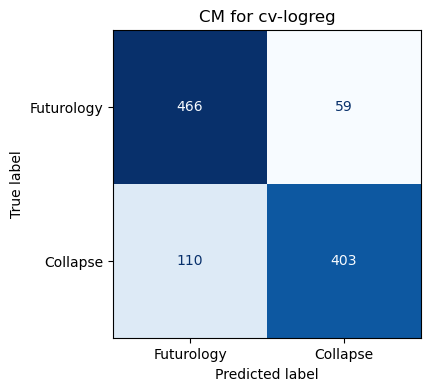

In [19]:
#logreg with countvectorizer
score_pipeline('cv', 'logreg')

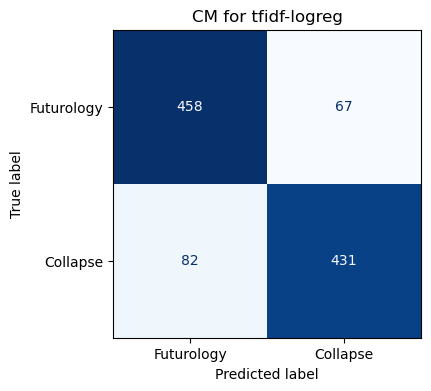

In [20]:
#logreg with tfidf vectorizer
score_pipeline('tfidf', 'logreg')

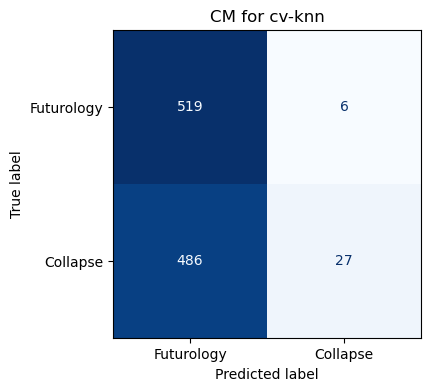

In [21]:
#knn with countvectorizer
score_pipeline('cv', 'knn')

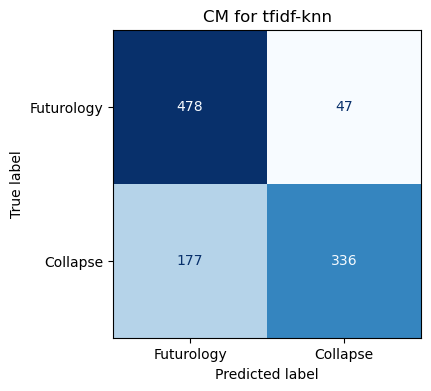

In [22]:
#knn with tfidf vectorizer
score_pipeline('tfidf', 'knn')

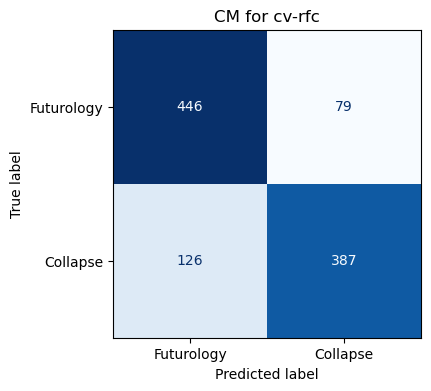

In [23]:
score_pipeline('cv', 'rfc')

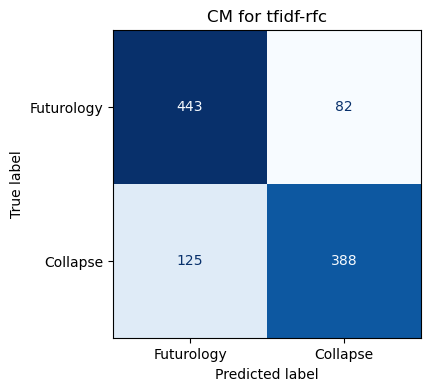

In [24]:
score_pipeline('tfidf', 'rfc')

In [25]:
#show all the scores
scores

,vectorizer,model,train,test,roc
pipeline,,,,,
cv-logreg,cv,logreg,0.9865,0.8372,0.8366
tfidf-logreg,tfidf,logreg,0.9509,0.8565,0.8563
cv-knn,cv,knn,0.9997,0.5260,0.5206
tfidf-knn,tfidf,knn,0.9997,0.7842,0.7827
cv-rfc,cv,rfc,0.9627,0.8025,0.8020
tfidf-rfc,tfidf,rfc,0.9682,0.8006,0.8001


The best model here is the Logistic Regression with a TFIDF vectorizer.

---
**Best Model Analysis**

The best model was the LogReg with TFIDF, so let's apply it to the full dataset and analyze it further.

In [26]:
full_df = pd.read_csv('../data/reddit.csv')
full_df.shape

(41514, 2)

In [27]:
X_full = full_df[['clean_text']]
y_full = full_df['is_collapse']

X_tr, X_ts, y_tr, y_ts = train_test_split(X_full, y_full, stratify=y_full, random_state=42)

In [28]:
X_tr_nlp = X_tr.applymap(nlp)
X_ts_nlp = X_ts.applymap(nlp)

In [29]:
X_tr_stops = X_tr_nlp.applymap(remove_stops)
X_ts_stops = X_ts_nlp.applymap(remove_stops)

In [30]:
#set the shape back to a series, not matrix
X_tr_full = X_tr_stops['clean_text']
X_ts_full = X_ts_stops['clean_text']

X_tr_full.shape, X_ts_full.shape, y_tr.shape, y_ts.shape

((31135,), (10379,), (31135,), (10379,))

In [31]:
pipe = Pipeline([('tfidf', tfidf), ('logreg', logreg)])
pipe.fit(X_tr_full, y_tr)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('logreg', LogisticRegression(n_jobs=-1, random_state=42))])

In [32]:
train_score = pipe.score(X_tr_full, y_tr)
test_score = pipe.score(X_ts_full, y_ts)
    
preds = pipe.predict(X_ts_full)
pred_probs = pipe.predict_proba(X_ts_full)
    
roc = roc_auc_score(y_ts, preds)

Training Score: 0.9188
Testing Score: 0.8837
ROC: 0.8837

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5248
           1       0.88      0.89      0.88      5131

    accuracy                           0.88     10379
   macro avg       0.88      0.88      0.88     10379
weighted avg       0.88      0.88      0.88     10379



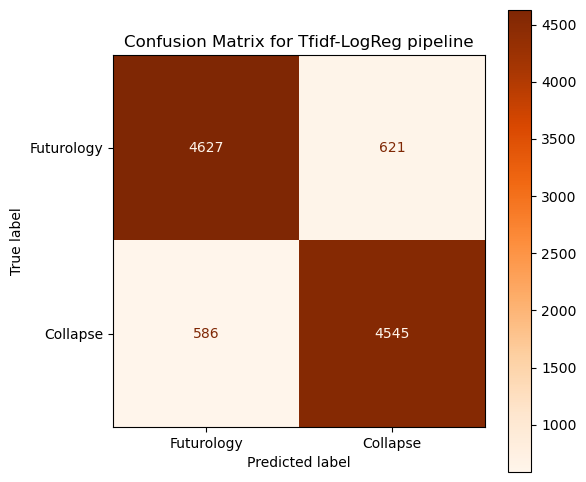

In [33]:
print(f'Training Score: {round(train_score,4)}\nTesting Score: {round(test_score,4)}\nROC: {round(roc,4)}')
print('\nClassification Report:')
print(classification_report(y_ts, preds))
    
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(pipe, X_ts_full, y_ts,
                                      display_labels=['Futurology','Collapse'], 
                                      cmap='Oranges', colorbar=True, ax=ax)
ax.set_title('Confusion Matrix for Tfidf-LogReg pipeline');

The model testing score and ROC actually improved when running it on the full dataset, which makes sense - we now have 10x the amount of data to train the model.  Overfitting was greatly reduced, because our dimensionality is better as well - we have more observations than features now.  

---
**Insights**

**Most Important Features**

In [34]:
# most important features
coefs = pd.DataFrame(columns=['feature_name', 'coef'])
coefs['coef'] = list(pipe.steps[1][1].coef_[0,:])
coefs['feature_name'] = list(pipe.steps[0][1].get_feature_names_out())

coefs = coefs.sort_values('coef', ascending=False)
coefs

,feature_name,coef
8116,climate,5.072274
42114,shit,4.145100
36448,prepare,3.846341
45469,survive,3.604197
45462,survival,3.579609
...,...,...
48505,ubi,-4.480272
3268,automation,-5.565172
46212,technology,-6.881217
985,ai,-6.885504


In [35]:
top_collapse = coefs.head(15)
top_futurology = coefs.tail(15)[::-1]

In [36]:
#these are the 'least important' words: coef=0.0
#however, there's not much insight to gain from this
#they are typos/cleaning errors or random terms that probably had low frequency

#it would be more interesting to find a way to pull the ngrams that are frequent in both subreddits
#but still have low feature importance
coefs[coefs['coef'].round(6)==0.0]

,feature_name,coef
26076,ladakh,2.942983e-07
12144,dfat,2.942983e-07
10160,crematorium,2.942983e-07
33860,paddlefish,2.942983e-07
42952,slums,2.942983e-07
27885,mainichi,2.942983e-07
18535,gansu,2.942983e-07
24212,ioc,2.942983e-07
27172,lmpd,2.942983e-07
18376,fwpd,2.942983e-07


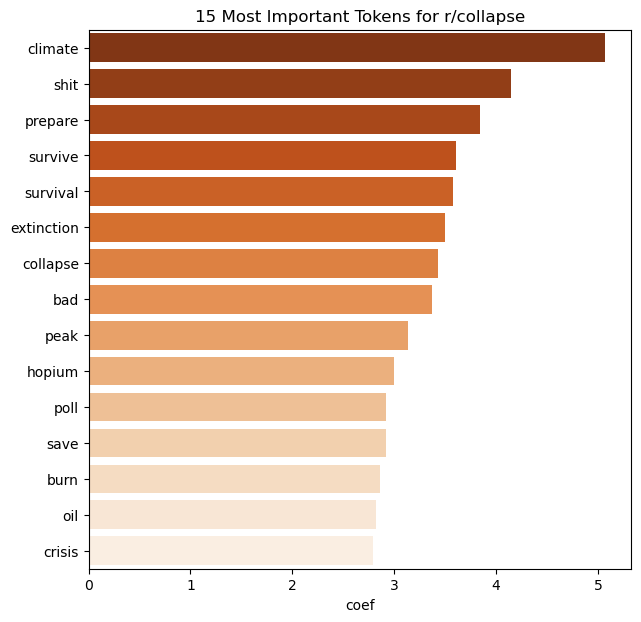

In [37]:
plt.figure(figsize=(7,7))
sns.barplot(data=top_collapse, x=abs(top_collapse['coef']), y=top_collapse['feature_name'], 
            palette='Oranges_r').set(title='15 Most Important Tokens for r/collapse', ylabel='');

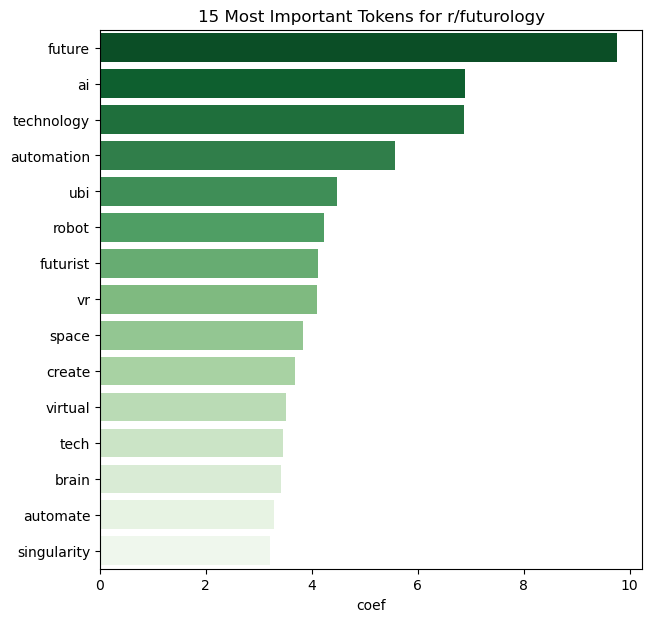

In [38]:
plt.figure(figsize=(7,7))
sns.barplot(data=top_futurology, x=abs(top_futurology['coef']), y=top_futurology['feature_name'], 
            palette='Greens_r').set(title='15 Most Important Tokens for r/futurology', ylabel='');

**Best Predictions and Misclassifications**

In [39]:
# predicted probabilities
pred_df = y_ts.to_frame()

pred_df['predictions'] = preds
pred_collapse = pred_probs[:,1]
pred_df['prob_is_collapse'] = pred_collapse
pred_df['clean_text'] = X_ts['clean_text']

pred_df = pred_df.sort_values('prob_is_collapse', ascending=False)

pred_df

,is_collapse,predictions,prob_is_collapse,clean_text
8676,1,1,0.999966,epic porn timeline to source the prophetic wor...
9115,1,1,0.999950,a brief timeline for w full citations hello a...
12,1,1,0.999925,last week in march april economic tensions ri...
7457,1,1,0.999699,the american election i predict a major of am...
15918,1,1,0.999691,it s time to start making preparations for you...
...,...,...,...,...
37225,0,0,0.000099,in the future there will be robots
26753,0,0,0.000031,what is the future
23026,0,0,0.000031,future future future future future future
29291,0,0,0.000031,back to the future


In [40]:
#posts with the highest probability of being r/collapse
#all of them are correctly predicted
pred_df.head(10)

,is_collapse,predictions,prob_is_collapse,clean_text
8676,1,1,0.999966,epic porn timeline to source the prophetic wor...
9115,1,1,0.999950,a brief timeline for w full citations hello a...
12,1,1,0.999925,last week in march april economic tensions ri...
7457,1,1,0.999699,the american election i predict a major of am...
15918,1,1,0.999691,it s time to start making preparations for you...
9783,1,1,0.999639,are the feedback loops as bad as people say th...
16877,1,1,0.999610,reasons to be calm i ve been close to suicidal...
10822,1,1,0.999581,the already arrived hiding behind the mask of...
6659,1,1,0.999538,signs of q hi r i have been working on an on...
9799,1,1,0.999518,copypasta of a pretty good guess on a negative...


In [41]:
#highest correlation to r/collapse
pred_df.loc[8676, 'clean_text'][:1000]

#only showing first 1000 characters for the sake of brevity
#this post has a lot of r/collapse characteristics: 'climate change', 'too late', 
#'security', 'dislocation' and plenty of other similar terms
#the post is a classic example of the doomsday mindset of r/collapse
#it's also very long (20_000 characters), which we saw is more common in r/collapse as well

'epic porn timeline to source the prophetic words of the german climatologist hans joachim schellnhuber in were smudged on the whiteboard climate change is now reaching the endgame where very soon humanity must choose between taking unprecedented action or accepting that it has been left too late and bear the consequences fifty years on those consequences were etched all over earth s surface as a small group of historians and scientists gathered in an annex of greenland s nuuk art museum kilometers south of the arctic circle to understand the course of events since those words were written living in a hotter world was all about food and water security and dislocation and war syria should have been a warning a preview of  in the world s top nine importers of wheat per capita had been middle eastern and north african nations when extreme fires in russia and a once in a century winter drought in china devastated wheat crops the global price for the grain and bread prices in the middle eas

From reddit, for readability:

> Epic CollapsePorn Timeline to 2070
<br>The prophetic words of the German climatologist Hans Joachim Schellnhuber in 2018 were smudged on the whiteboard: “Climate change is now reaching the endgame, where very soon humanity must choose between taking unprecedented action, or accepting that it has been left too late and bear the consequences” . Fifty years on, those consequences were etched all over Earth’s surface, as a small group of historians and scientists gathered in an annex of Greenland’s Nuuk Art Museum, 240 kilometers south of the Arctic Circle, to understand the course of events since those words were written.
<br>2020 Living in a hotter world was all about food and water security – and dislocation and war. Syria should have been a warning, a preview of collapse.
<br>In 2010, the world’s top nine importers of wheat, per capita, had been Middle Eastern and North African nations. When extreme fires in Russia and a “once-in-a-century” winter drought in China devastated wheat crops, the global price for the grain, and bread prices in the Middle East, spiked. In some cases they tripled, and food riots became a trigger for the Arab Spring uprisings in seven of those nine wheat-importing states.
<br>...

In [42]:
#posts with the highest probability of being r/futurology
#all of them are correctly predicted
pred_df.tail(10)[::-1]

,is_collapse,predictions,prob_is_collapse,clean_text
36086,0,0,0.000031,the future is the here and now only more so
29291,0,0,0.000031,back to the future
23026,0,0,0.000031,future future future future future future
26753,0,0,0.000031,what is the future
37225,0,0,0.000099,in the future there will be robots
34431,0,0,0.000150,i can t wait for the future to get here who is...
23399,0,0,0.000179,how ai powered devices are remodeling the cons...
32135,0,0,0.000250,do you have time to think about technology amp...
23662,0,0,0.000257,top ai in ces for the future i will discuss ab...
32361,0,0,0.000262,which technological inventions besides ai and ...


In [43]:
#highest correlation to r/futurology
pred_df.loc[32361, 'clean_text'][:1000]

#suprisingly, it happens to be a pretty short post already
#but it uses 'technological', 'ai', and 'future' which are three of 
#the top tokens in r/futurology

'which technological inventions besides ai and self driving vehicles going to be well established in the future what do you think'

From reddit, for readbility:
> Which technological inventions besides AI and self-driving vehicles going to be well established in the future?
<br>What do you think?

In [44]:
#10 posts hardest to predict - close to 50% probabilty
#6 of these were correct, 4 were correct
pred_df[(pred_df.prob_is_collapse > 0.4992) & (pred_df.prob_is_collapse < 0.5009)]

,is_collapse,predictions,prob_is_collapse,clean_text
10935,1,1,0.500874,apr to june gfs temp abnormalities model apr t...
3195,1,1,0.500644,in fiction star wars how successful was the g...
11022,1,1,0.500596,look at all the dystopian timelines we re gett...
38839,0,1,0.500531,is there precedent or law already laid down co...
14041,1,1,0.500025,meta are colllapse mods retarded
4409,1,0,0.499902,would hawaii sit out a hypothetical civil war ...
7527,1,0,0.499865,can t visualize the future i am currently appl...
21738,0,0,0.499685,herpes diagnose being diagnosed with herpes is...
28954,0,0,0.499670,considerations towards m a d tesla s faraday c...
10408,1,0,0.499231,lifeboat ethics in the anthropocene


In [45]:
#misclassified posts:
pred_df.loc[38839, 'clean_text']
#this post doesn't seem to touch on any of the common features 
#in either subreddit: 'climate change', 'ai', 'extinction', 'robot',
#so since it's a very different topic, it would've been harder to predict.
#this post was actually r/futurology, but the model predicted it was r/collapse

'is there precedent or law already laid down concerning the joining of nations into new territories nations states could the usa and canada become canadamerica americanada i was watching continuum and realized that i had no idea about international law concerning the creation of new nations between current ones not necessarily ca and us but a number between some and all of the world s nation states will reform and or combine at some point in the future'

From reddit:
> Is there precedent or law already laid down concerning the joining of nations into new territories/nations/states? Could the USA and Canada become Canadamerica/Americanada?
<br>I was watching Continuum and realized that I had no idea about international law concerning the creation of new nations between current ones. Not necessarily CA and US, but a number between some and all of the world's nation states will reform and/or combine at some point in the future.

In [46]:
pred_df.loc[4409, 'clean_text']
#again, this post doesn't cover any of the topics which show up in the important tokens
#it's also pretty short, so it doesn't have much info to share with the model
#however, this shows a limitation of our model: 
#'hypothetical civil war' stands out to me as a r/collapse topic, 
#but the model predicted this one as r/futurology because we only used one-word ngrams

'would hawaii sit out a hypothetical civil war since it s pretty far from the mainland'

From reddit:
> Would Hawaii sit out a hypothetical civil war?
<br>Since it's pretty far from the mainland...

In [47]:
pred_df.loc[7527, 'clean_text']
#it is surprising that this post was misclassified.
#it talks about 'climate change' and 'inevitable downfall' and 'terrifying'
#but it also mentions 'the future' a couples and that could be why the model
#incorrectly classified it as r/futurology

'can t visualize the future i am currently applying to college in recent years i have grown incredibly despondent about climate change and what i see as the inevitable downfall of the world as we know it however in the short term i still need to go to college which means writing essays about what i want to do in the future i usually end up in tears because when i was younger i wanted to start a family and live to old age but now i genuinely am unable to imagine myself past the age of maybe it s terrifying to me that at the time of my life when i ll be qualified to help with the climate it might be too late'

From reddit:
> Can't visualize the future.
<br>I am currently applying to college. In recent years I have grown incredibly despondent about climate change and what I see as the inevitable downfall of the world as we know it. However, in the short term, I still need to go to college, which means writing essays about what I want to do in the future. I usually end up in tears because when I was younger I wanted to start a family and live to old age but now I genuinely am unable to imagine myself past the age of maybe 30? It's terrifying to me that at the time of my life when I'll be qualified to help with the climate, it might be too late.

In [48]:
pred_df.loc[10408, 'clean_text']
#this post is too short for the model to successfully predict it
#as a human, i wouldn't be able to guess which reddit it's from either

'lifeboat ethics in the anthropocene '

From reddit:
> LIFEBOAT ETHICS In The Anthropocene